Before running, make sure the requirements have been installed correctly.

In [1]:
import json

from jax import random
import jax
import jax.numpy as jnp

import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC, MixedHMC, DiscreteHMCGibbs
from numpyro.infer.reparam import TransformReparam
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm

import matplotlib.pyplot as plt

/Users/danielmanela/.virtualenvs/causal-copulas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testing out performance time with high correlations

In this example we work with the following model:
$$Z~\sim~\mathcal{N}(0, 1) \\ X~|~Z~\sim~\mathcal{N}( \rho_{XZ} Z,~1 - \rho_{XZ}^{2}) \\ Y~|~\text{do}(X) \sim \mathcal{N}(X - 0.5,~1)$$
with a gaussian copula correlation of $\rho_{YZ}=\text{expit}(1)$.

## Centered vs. Non Centered Parameterisations
Sampling problems arise when dealing with highly correlated variables. In Hamiltonian Monte Carlo (HMC) and NUTS samplers, traverising across a highly correlated posterior results in either divergent transitions or very slow transition steps as transitions are generally calculated agnostic of _where_ in the posterior space they lie.

If $\rho_{XZ}$ is very close to 1 (say 0.99), by definition $X$ and $Z$ will be highly correlated and sampling will be inefficient. We can improve upon things by using a non-centered parameterisation, where we capture the same data generating setup as the centered parameterisation above. Through introducing two standard gaussian RVs $U_1, U_2$, we can do the following:

$$ Z~\sim~\mathcal{N}(0, 1) \\ \mathbf{U}~\sim~\mathcal{N}(\mathbf{0}, \mathbf{I}) \\ X~|~Z=\rho_{XZ}\cdot Z + (\sqrt{1-\rho_{XZ}^2}\cdot U_1) \\ Y~|~\text{do}(X) = X - 0.5 + U_2$$

The generating distributions are the same, but instead of sampling from highly correlated parameters, we sample from a multivariate standard Gaussian formed by $(Z,~U_1,~U_2)$.

**The function below allows you to sample from either using the** `noncentered_param` **arguement.**

#### **SPOILERS**: For some reason I'm getting divergences from the Non-centered models. Perhaps the CDF/ICDF transformations are difficult to deal with? Need to explore further.

In [2]:
num_warmup = 1000
num_samples = 1000

### Testing with constant $\rho_{YZ}$

In [3]:
def gaussian_copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )


def high_correlations(y=None, rho=0., centered_param=True):
    Z = numpyro.sample("z", dist.Normal(0, 1))
    
    if centered_param:
        X = numpyro.sample("x", dist.Normal(rho*Z, jnp.sqrt(1 - jnp.square(rho))))
        Y = numpyro.sample("y", dist.Normal(-0.5 + X, 1))
    else:
        U1 = numpyro.sample("u1", dist.Normal(0, 1))
        U2 = numpyro.sample("u2", dist.Normal(0, 1))        
        X = numpyro.deterministic("x", rho * Z + jnp.sqrt(1 - jnp.square(rho)) * U1)
        Y = numpyro.deterministic("y", X + U2 - 0.5)
    
    quantiles_Y = numpyro.deterministic('q_Y', dist.Normal(-0.5 + X, 1).cdf(Y))    
    quantiles_Z = numpyro.deterministic('q_Z', dist.Normal(0, 1).cdf(Z))
    
    # Choosing an arbitrary sigmoidal function for rho_ly
    rho_ZY_val = numpyro.deterministic('rho_ly', jax.nn.sigmoid(1.))
    
    std_normal_Z = numpyro.deterministic('std_normal_z', dist.Normal(0, 1).icdf(quantiles_Z))
    std_normal_Y = numpyro.deterministic('std_normal_y', dist.Normal(0, 1).icdf(quantiles_Y))
    cop_log_prob = numpyro.factor('cop_log_prob', gaussian_copula_lpdf(std_normal_Z, std_normal_Y, rho_ZY_val))

In [4]:
def generate_samples(model, num_warmup, num_samples, rho, centered_param=False):
    kernel = NUTS(model)
    mcmc_model = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples, 
        progress_bar=True
    )
    mcmc_model.run(
        random.PRNGKey(1),
        rho=rho,
        centered_param=centered_param
    )
    mcmc_model.print_summary()
    return mcmc_model.get_samples()

Time to test across different types of $\rho_{XZ}$:

$$\rho_{XZ} \in \{0.5, 0.9, 0.99, 0.9999\}$$

#### $\rho_{XZ} = 0.5$

In [5]:
centered_samples_rho_05 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.5, centered_param=True) 
noncentered_samples_rho_05 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.5, centered_param=False)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 763.61it/s, 15 steps of size 3.42e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.02      1.01      0.00     -1.57      1.77    318.77      1.00
         y     -0.55      1.66     -0.53     -3.02      2.06    299.46      1.00
         z     -0.04      1.00     -0.05     -1.58      1.63    386.70      1.00

Number of divergences: 0


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 771.10it/s, 7 steps of size 5.47e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.04      1.02      0.06     -1.59      1.66    660.19      1.00
        u2      0.01      1.01     -0.00     -1.55      1.74    631.68      1.00
         z      0.02      0.99      0.02     -1.56      1.57    588.09      1.00

Number of divergences: 0


In [6]:
print(f"C Var: {jnp.var(centered_samples_rho_05['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['z'])}")

C Var: 0.9931579828262329
NC Var: 0.9856705665588379


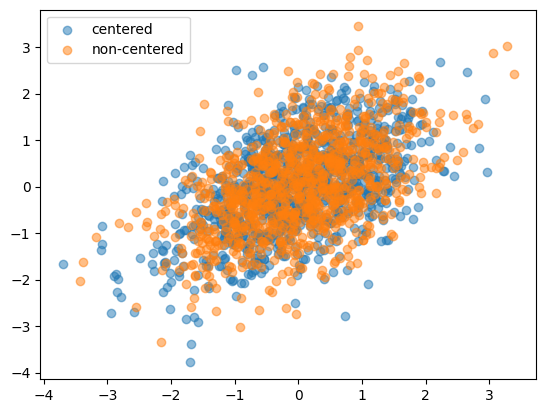

In [7]:
plt.scatter(centered_samples_rho_05['z'],centered_samples_rho_05['x'], label='centered', alpha=0.5);
plt.scatter(noncentered_samples_rho_05['z'],noncentered_samples_rho_05['x'], label='non-centered', alpha=0.5);
plt.legend();

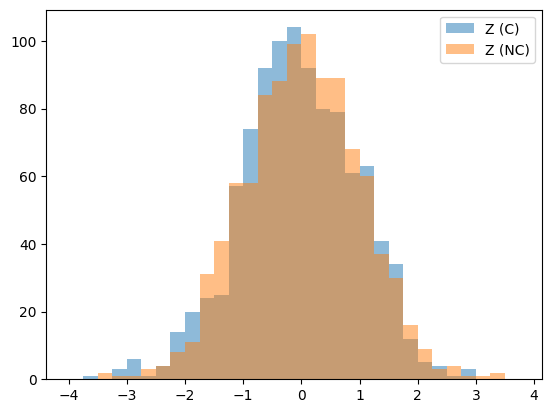

In [8]:
plt.hist(centered_samples_rho_05['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [9]:
print(f"C Var: {jnp.var(centered_samples_rho_05['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['x'])}")

C Var: 1.0104562044143677
NC Var: 1.0539058446884155


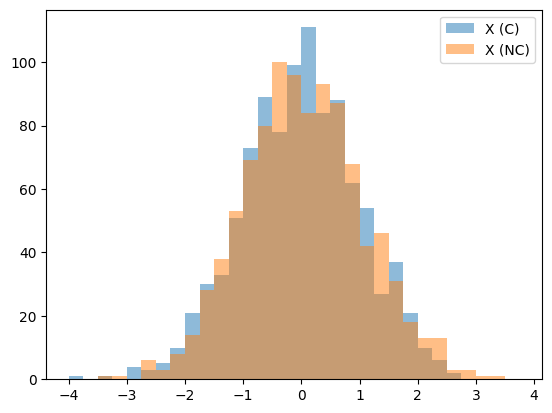

In [10]:
plt.hist(centered_samples_rho_05['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [11]:
print(f"C Var: {jnp.var(centered_samples_rho_05['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['y'])}")

C Var: 2.7511582374572754
NC Var: 2.8268818855285645


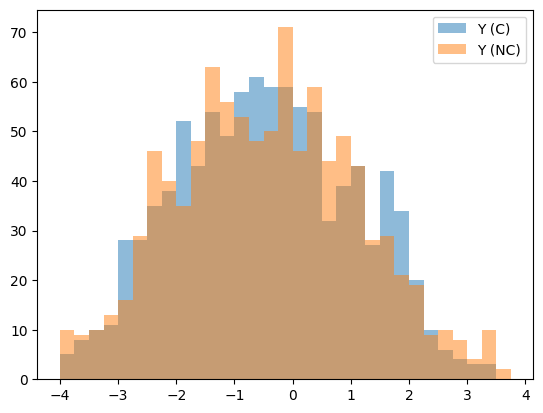

In [12]:
plt.hist(centered_samples_rho_05['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.9$

In [13]:
centered_samples_rho_09 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9, centered_param=True) 
noncentered_samples_rho_09 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9, centered_param=False)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 785.08it/s, 15 steps of size 2.71e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.01      0.93      0.01     -1.51      1.48    207.08      1.00
         y     -0.50      1.69     -0.51     -3.41      1.98    206.73      1.00
         z      0.01      0.96      0.04     -1.57      1.51    212.36      1.00

Number of divergences: 0


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 781.01it/s, 7 steps of size 6.65e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.01      1.00      0.04     -1.61      1.61    742.14      1.00
        u2      0.04      1.01      0.01     -1.64      1.64    560.91      1.00
         z      0.06      1.01      0.03     -1.43      1.83    549.04      1.01

Number of divergences: 0


In [14]:
print(f"C Var: {jnp.var(centered_samples_rho_09['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['z'])}")

C Var: 0.9166214466094971
NC Var: 1.0125324726104736


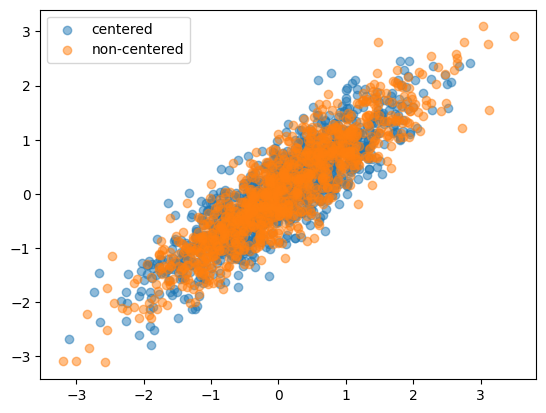

In [15]:
plt.scatter(centered_samples_rho_09['z'],centered_samples_rho_09['x'], label='centered', alpha=0.5);
plt.scatter(noncentered_samples_rho_09['z'],noncentered_samples_rho_09['x'], label='non-centered', alpha=0.5);
plt.legend()

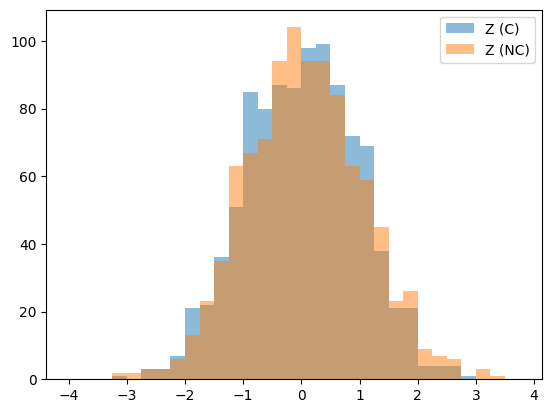

In [16]:
plt.hist(centered_samples_rho_09['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [17]:
print(f"C Var: {jnp.var(centered_samples_rho_09['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['x'])}")

C Var: 0.8714783787727356
NC Var: 0.9798964858055115


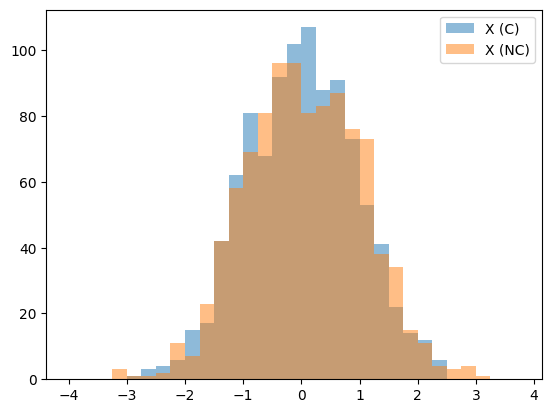

In [18]:
plt.hist(centered_samples_rho_09['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [19]:
print(f"C Var: {jnp.var(centered_samples_rho_09['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['y'])}")

C Var: 2.864978551864624
NC Var: 3.351478099822998


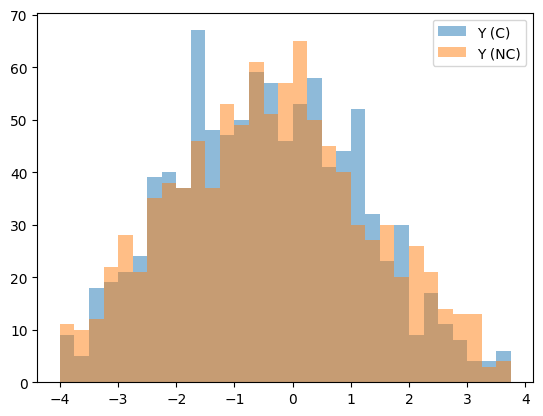

In [20]:
plt.hist(centered_samples_rho_09['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.99$

In [21]:
centered_samples_rho_099 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.99, centered_param=True) 
noncentered_samples_rho_099 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.99, centered_param=False)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 742.34it/s, 43 steps of size 9.44e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.11      1.04     -0.10     -1.64      1.61    125.44      1.01
         y     -0.67      1.93     -0.67     -3.46      2.36    132.21      1.01
         z     -0.11      1.03     -0.09     -1.61      1.60    122.81      1.01

Number of divergences: 0


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 772.34it/s, 7 steps of size 5.71e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.02      1.03      0.02     -1.61      1.69    738.17      1.01
        u2      0.01      1.02      0.01     -1.67      1.60    672.55      1.00
         z      0.05      1.01      0.02     -1.56      1.66    634.60      1.00

Number of divergences: 0


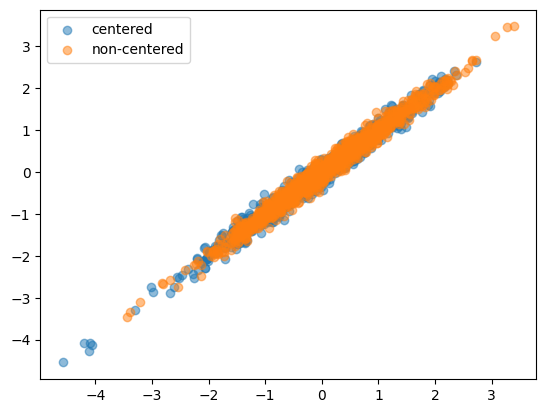

In [22]:
plt.scatter(centered_samples_rho_099['z'],centered_samples_rho_099['x'], label='centered', alpha=0.5);
plt.scatter(noncentered_samples_rho_099['z'],noncentered_samples_rho_099['x'], label='non-centered', alpha=0.5);
plt.legend()

In [23]:
print(f"C Var: {jnp.var(centered_samples_rho_099['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['z'])}")

C Var: 1.0590399503707886
NC Var: 1.016548991203308


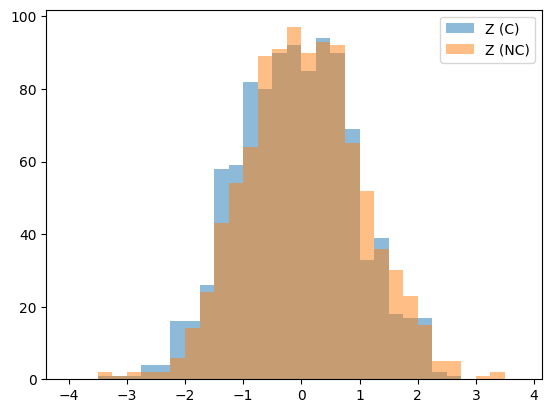

In [24]:
plt.hist(centered_samples_rho_099['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [25]:
print(f"C Var: {jnp.var(centered_samples_rho_099['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['x'])}")

C Var: 1.0710588693618774
NC Var: 1.0286709070205688


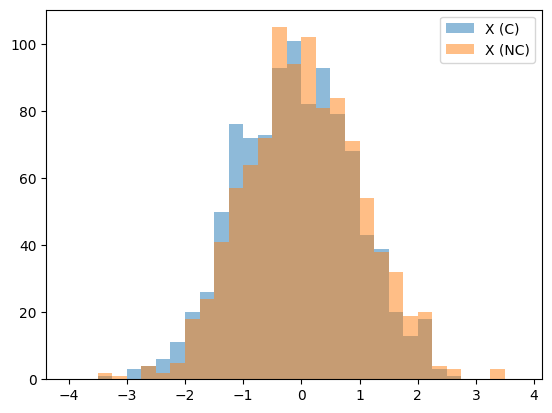

In [26]:
plt.hist(centered_samples_rho_099['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [27]:
print(f"C Var: {jnp.var(centered_samples_rho_099['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['y'])}")

C Var: 3.7285964488983154
NC Var: 3.5368428230285645


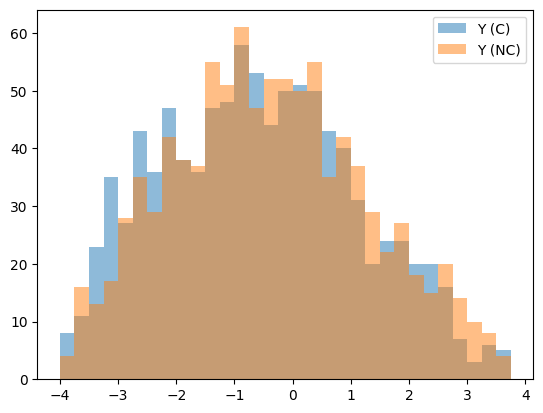

In [28]:
plt.hist(centered_samples_rho_099['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.9999$

In [29]:
centered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9999, centered_param=True) 
noncentered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9999, centered_param=False)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 766.62it/s, 399 steps of size 8.47e-03. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.02      1.04     -0.05     -1.78      1.48    113.22      1.00
         y     -0.56      1.95     -0.63     -3.48      2.62    111.86      1.00
         z     -0.01      1.04     -0.05     -1.76      1.51    113.22      1.00

Number of divergences: 0


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 778.39it/s, 7 steps of size 5.47e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.04      0.99      0.05     -1.48      1.68    762.85      1.00
        u2     -0.02      1.00     -0.03     -1.64      1.63    640.16      1.00
         z      0.00      0.99      0.01     -1.59      1.55    601.90      1.00

Number of divergences: 0


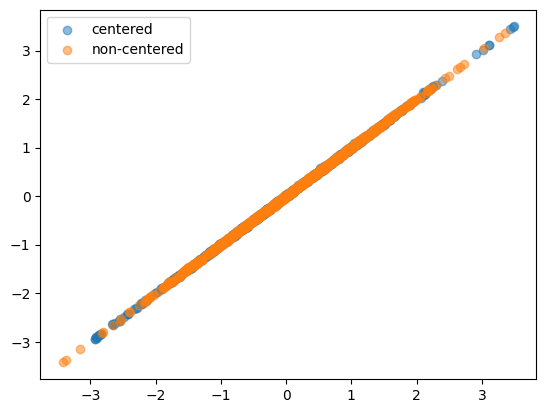

In [30]:
plt.scatter(centered_samples_rho_09999['z'],centered_samples_rho_09999['x'], label='centered', alpha=0.5);
plt.scatter(noncentered_samples_rho_09999['z'],noncentered_samples_rho_09999['x'], label='non-centered', alpha=0.5);
plt.legend();

In [31]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['z'])}")

C Var: 1.087552785873413
NC Var: 0.9813224673271179


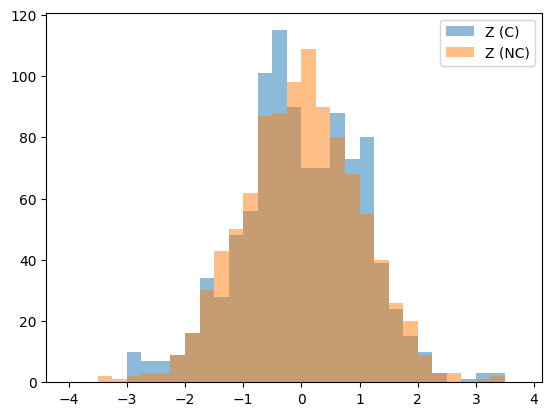

In [32]:
plt.hist(centered_samples_rho_09999['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [33]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['x'])}")

C Var: 1.0870862007141113
NC Var: 0.9818572998046875


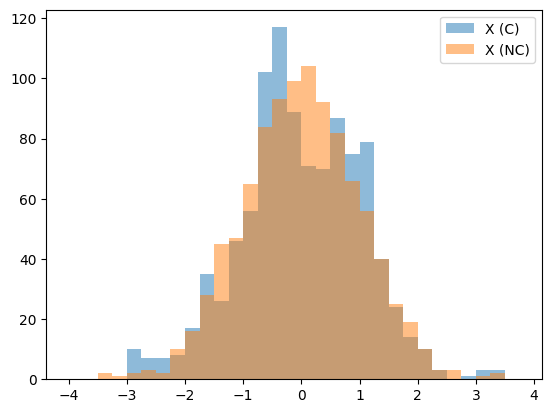

In [34]:
plt.hist(centered_samples_rho_09999['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [35]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['y'])}")

C Var: 3.8102166652679443
NC Var: 3.4459805488586426


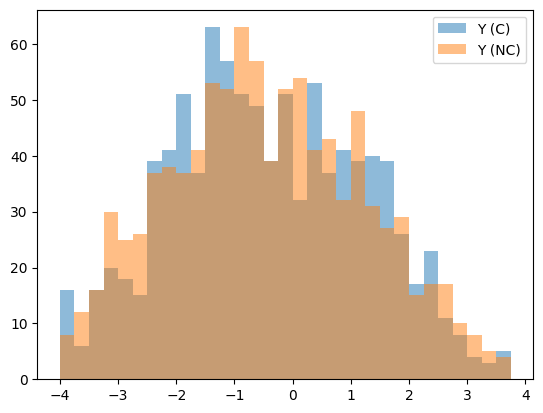

In [36]:
plt.hist(centered_samples_rho_09999['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [37]:
pd.DataFrame(centered_samples_rho_05)[['x', 'y', 'z']].to_csv('constant_copula_samples_rho_05.csv', index=False)
pd.DataFrame(centered_samples_rho_09)[['x', 'y', 'z']].to_csv('constant_copula_samples_rho_09.csv', index=False)
pd.DataFrame(centered_samples_rho_099)[['x', 'y', 'z']].to_csv('constant_copula_samples_rho_099.csv', index=False)

### Testing with $\rho_{YZ} | X = \text{expit}(X)$

In [38]:
def gaussian_copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )


def high_correlations(y=None, rho=0., centered_param=True):
    Z = numpyro.sample("z", dist.Normal(0, 1))
    
    if centered_param:
        X = numpyro.sample("x", dist.Normal(rho*Z, jnp.sqrt(1 - jnp.square(rho))))
        Y = numpyro.sample("y", dist.Normal(-0.5 + X, 1))
    else:
        U1 = numpyro.sample("u1", dist.Normal(0, 1))
        U2 = numpyro.sample("u2", dist.Normal(0, 1))        
        X = numpyro.deterministic("x", rho * Z + jnp.sqrt(1 - jnp.square(rho)) * U1)
        Y = numpyro.deterministic("y", X + U2 - 0.5)
    
    quantiles_Y = numpyro.deterministic('q_Y', dist.Normal(-0.5 + X, 1).cdf(Y))    
    quantiles_Z = numpyro.deterministic('q_Z', dist.Normal(0, 1).cdf(Z))
    
    # Choosing an arbitrary sigmoidal function for rho_ly
    rho_ZY_val = numpyro.deterministic('rho_ly', jax.nn.sigmoid(X))
    
    std_normal_Z = numpyro.deterministic('std_normal_z', dist.Normal(0, 1).icdf(quantiles_Z))
    std_normal_Y = numpyro.deterministic('std_normal_y', dist.Normal(0, 1).icdf(quantiles_Y))
    cop_log_prob = numpyro.factor('cop_log_prob', gaussian_copula_lpdf(std_normal_Z, std_normal_Y, rho_ZY_val))

In [39]:
def generate_samples(model, num_warmup, num_samples, rho, centered_param=False):
    kernel = NUTS(model)
    mcmc_model = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples, 
        progress_bar=True
    )
    mcmc_model.run(
        random.PRNGKey(1),
        rho=rho,
        centered_param=centered_param
    )
    mcmc_model.print_summary()
    return mcmc_model.get_samples()

Time to test across different types of $\rho_{XZ}$:

$$\rho_{XZ} \in \{0.5, 0.9, 0.99, 0.9999\}$$

#### $\rho_{XZ} = 0.5$

In [40]:
centered_samples_rho_05 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.5, centered_param=True) 
noncentered_samples_rho_05 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.5, centered_param=False)

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 763.11it/s, 3 steps of size 5.04e-01. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.11      0.92     -0.13     -1.51      1.51    345.88      1.00
         y     -0.58      1.43     -0.67     -2.98      1.56    393.07      1.00
         z     -0.08      0.97     -0.08     -1.77      1.38    471.81      1.00

Number of divergences: 20


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 764.22it/s, 3 steps of size 5.65e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1     -0.07      0.96     -0.07     -1.75      1.39    707.76      1.00
        u2      0.10      0.95      0.11     -1.38      1.74    763.19      1.00
         z      0.02      0.99      0.02     -1.53      1.64    702.44      1.00

Number of divergences: 0


In [41]:
print(f"C Var: {jnp.var(centered_samples_rho_05['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['z'])}")

C Var: 0.9362722039222717
NC Var: 0.9833674430847168


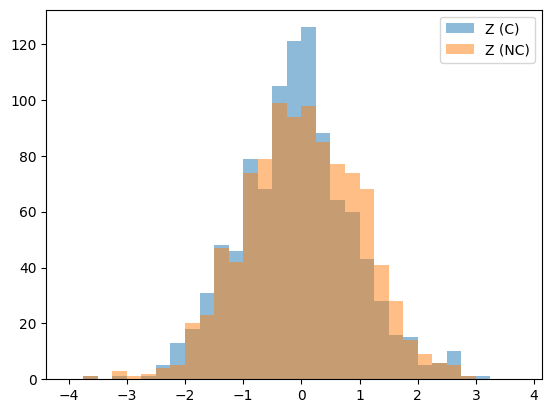

In [42]:
plt.hist(centered_samples_rho_05['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [43]:
print(f"C Var: {jnp.var(centered_samples_rho_05['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['x'])}")

C Var: 0.8528973460197449
NC Var: 0.8770551681518555


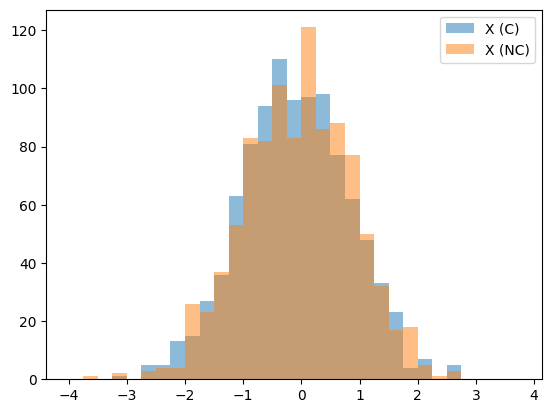

In [44]:
plt.hist(centered_samples_rho_05['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [45]:
print(f"C Var: {jnp.var(centered_samples_rho_05['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['y'])}")

C Var: 2.050238847732544
NC Var: 2.0477893352508545


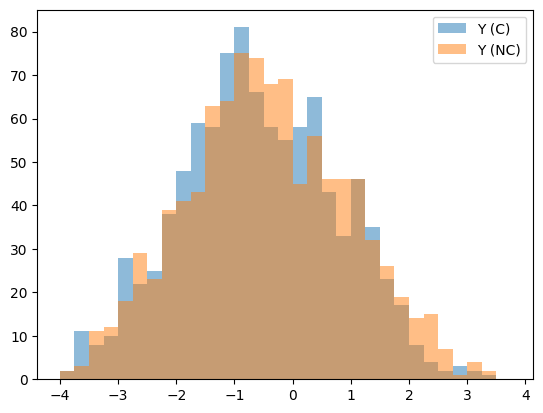

In [46]:
plt.hist(centered_samples_rho_05['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.9$

In [47]:
centered_samples_rho_09 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9, centered_param=True) 
noncentered_samples_rho_09 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9, centered_param=False)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 793.46it/s, 15 steps of size 2.73e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.11      0.94     -0.13     -1.46      1.44    187.58      1.00
         y     -0.44      1.57     -0.52     -3.10      1.91    212.51      1.00
         z     -0.09      0.95     -0.07     -1.59      1.44    189.56      1.00

Number of divergences: 2


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 779.78it/s, 7 steps of size 5.89e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1     -0.04      0.98     -0.01     -1.70      1.46    802.82      1.00
        u2      0.17      0.98      0.17     -1.42      1.82    635.68      1.00
         z     -0.06      1.00     -0.08     -1.74      1.55    569.94      1.00

Number of divergences: 3


In [48]:
print(f"C Var: {jnp.var(centered_samples_rho_09['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['z'])}")

C Var: 0.8940605521202087
NC Var: 0.9943188428878784


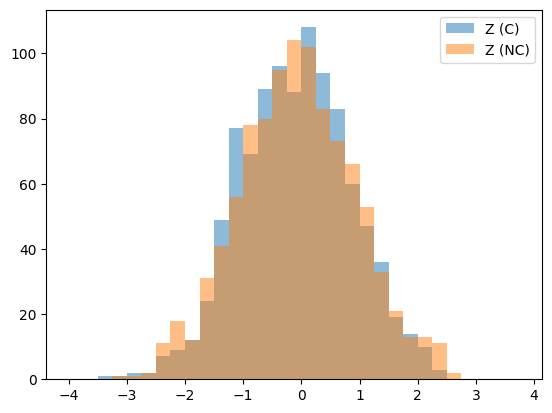

In [49]:
plt.hist(centered_samples_rho_09['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [50]:
print(f"C Var: {jnp.var(centered_samples_rho_09['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['x'])}")

C Var: 0.8836115598678589
NC Var: 0.941752552986145


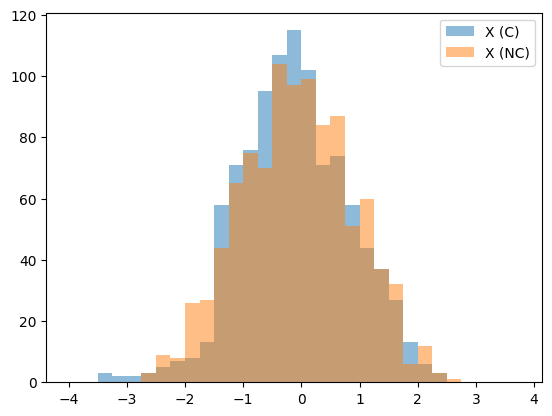

In [51]:
plt.hist(centered_samples_rho_09['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [52]:
print(f"C Var: {jnp.var(centered_samples_rho_09['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['y'])}")

C Var: 2.4636714458465576
NC Var: 2.6618642807006836


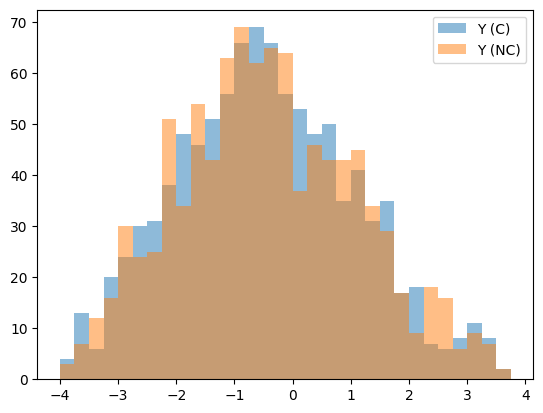

In [53]:
plt.hist(centered_samples_rho_09['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.99$

In [54]:
centered_samples_rho_099 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.99, centered_param=True) 
noncentered_samples_rho_099 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.99, centered_param=False)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 783.81it/s, 55 steps of size 9.62e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.12      0.91     -0.07     -1.57      1.37    179.79      1.00
         y     -0.50      1.51     -0.57     -3.31      1.74    200.59      1.00
         z     -0.12      0.91     -0.07     -1.65      1.23    177.91      1.00

Number of divergences: 0


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 830.33it/s, 7 steps of size 5.91e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.06      1.04      0.05     -1.72      1.61    777.20      1.00
        u2      0.23      1.03      0.26     -1.29      2.05    627.57      1.01
         z     -0.05      0.99     -0.05     -1.69      1.49    529.09      1.00

Number of divergences: 2


In [55]:
print(f"C Var: {jnp.var(centered_samples_rho_099['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['z'])}")

C Var: 0.8286618590354919
NC Var: 0.9727897047996521


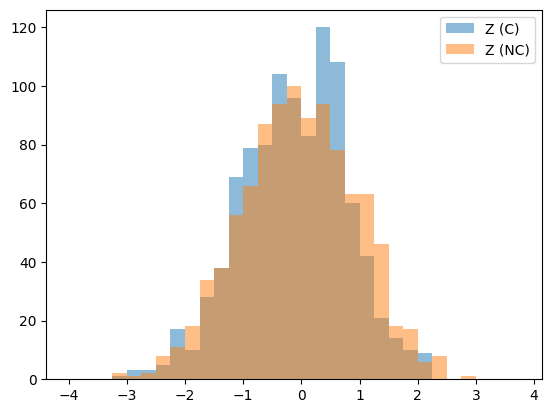

In [56]:
plt.hist(centered_samples_rho_099['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [57]:
print(f"C Var: {jnp.var(centered_samples_rho_099['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['x'])}")

C Var: 0.8244819045066833
NC Var: 0.9835805892944336


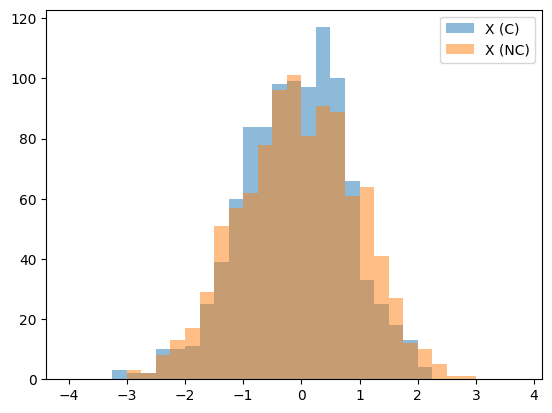

In [58]:
plt.hist(centered_samples_rho_099['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [59]:
print(f"C Var: {jnp.var(centered_samples_rho_099['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['y'])}")

C Var: 2.290607213973999
NC Var: 2.888904333114624


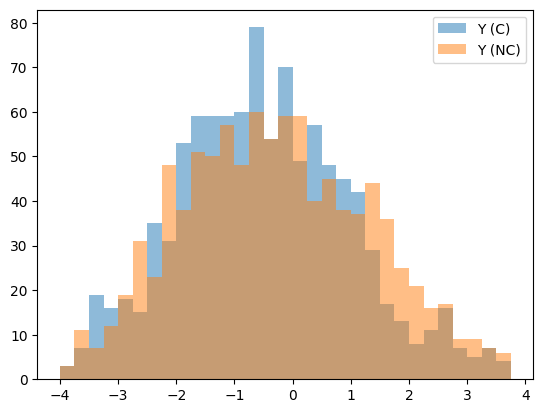

In [60]:
plt.hist(centered_samples_rho_099['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

#### $\rho_{XZ} = 0.9999$

In [61]:
centered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9999, centered_param=True) 
noncentered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=num_warmup, num_samples=num_samples, rho=0.9999, centered_param=False)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 798.75it/s, 243 steps of size 9.79e-03. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.12      0.94     -0.06     -1.51      1.47     79.42      1.02
         y     -0.48      1.67     -0.52     -3.07      2.29    126.52      1.00
         z     -0.12      0.94     -0.06     -1.52      1.46     79.36      1.02

Number of divergences: 0


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 790.34it/s, 7 steps of size 5.76e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.04      1.05     -0.01     -1.82      1.60    633.32      1.01
        u2      0.22      1.04      0.26     -1.45      1.94    589.09      1.00
         z      0.02      0.96      0.02     -1.54      1.55    576.51      1.00

Number of divergences: 4


In [62]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['z'])}")

C Var: 0.8833789825439453
NC Var: 0.9112197756767273


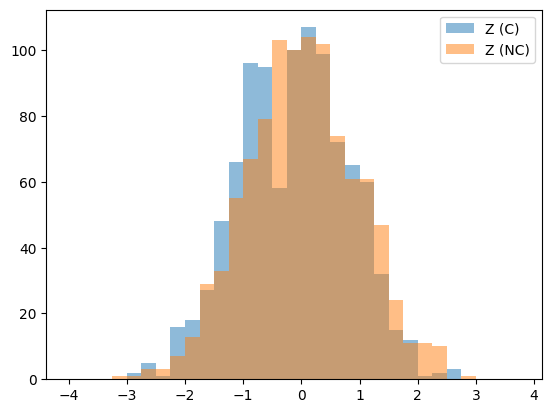

In [63]:
plt.hist(centered_samples_rho_09999['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [64]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['x'])}")

C Var: 0.8829810619354248
NC Var: 0.9120061993598938


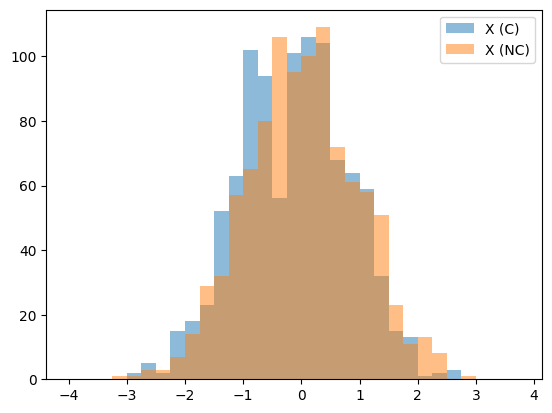

In [65]:
plt.hist(centered_samples_rho_09999['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [66]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['y'])}")

C Var: 2.7923617362976074
NC Var: 2.9414515495300293


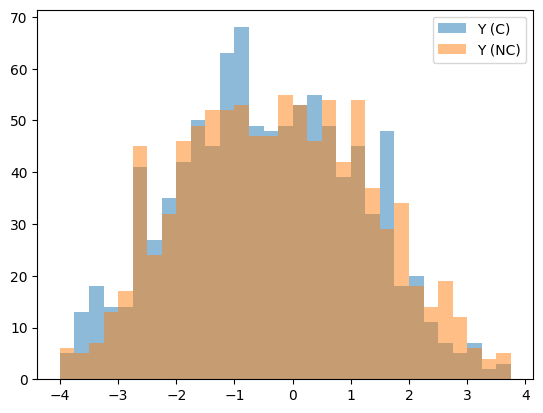

In [67]:
plt.hist(centered_samples_rho_09999['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

## Regression is a pain in python, saving and reading using R

In [68]:
pd.DataFrame(centered_samples_rho_05)[['x', 'y', 'z']].to_csv('variable_copula_samples_rho_05.csv', index=False)
pd.DataFrame(centered_samples_rho_099)[['x', 'y', 'z']].to_csv('variable_copula_samples_rho_09.csv', index=False)
pd.DataFrame(centered_samples_rho_099)[['x', 'y', 'z']].to_csv('variable_copula_samples_rho_099.csv', index=False)